In [1]:
import matplotlib.pyplot as plt

import time
import os
import dask
import dask.dataframe as dd
import dask.array as da
from distributed.utils import format_bytes

import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, precision_score, recall_score

from dpyacl.strategies.single_label import QueryMarginSampling
from dpyacl.core.stop_criteria import MaxIteration
from dpyacl.experiment import ExperimentAnalyserFactory
from dpyacl.experiment.context import HoldOutExperiment
from dpyacl.experiment.context import CrossValidationExperiment
from dpyacl.metrics import Accuracy
from dpyacl.metrics.evaluation import F1, Precision, Recall, HammingLoss
from dpyacl.oracle import SimulatedOracleQueryIndex
from dpyacl.scenario.scenario import PoolBasedSamplingScenario
from dpyacl.core.misc import split


In [2]:

from dask.distributed import Client
client = Client('tcp://192.168.2.100:8786')
client

Client Scheduler: tcp://192.168.2.100:8786 Dashboard: http://192.168.2.100:8787/status,Cluster Workers: 5 Cores: 10 Memory: 15.00 GB


In [4]:
data=load_breast_cancer() #import the dataset
X = da.from_array(data.data, chunks=len(data.data)// 50)
y = da.from_array(data.target, chunks=len(data.target)// 50)


from distributed.utils import format_bytes
format_bytes(X.nbytes)

'136.56 kB'

In [4]:
iterations = []
for i in range (0,1) :
    X,y=load_breast_cancer(return_X_y=True) #import the dataset

    # data=load_breast_cancer()
    # X = da.from_array(data.data, chunks=len(X)// 50).persist()
    # y = da.from_array(data.target, chunks=len(y)// 50).persist()
    # client.rebalance(X)
    # client.rebalance(y)

    ml_technique = LogisticRegression(solver='sag')
    stopping_criteria = MaxIteration(25)
    query_strategy = QueryMarginSampling()
    performance_metrics = [Accuracy(),  F1(average='weighted'), HammingLoss()]

    # # init the ALExperiment
    # experiment = HoldOutExperiment(
    #     client,
    #     X,
    #     y,
    #     scenario_type=PoolBasedSamplingScenario,
    #     ml_technique=ml_technique,
    #     performance_metrics=performance_metrics,
    #     query_strategy=query_strategy,
    #     oracle=SimulatedOracleQueryIndex(labels=y),
    #     stopping_criteria=stopping_criteria,
    #     self_partition=True,
    #     test_ratio=0.3,
    #     initial_label_rate=0.05,
    #     all_class=False,
    #     rebalance=True
    # )

    experiment = CrossValidationExperiment(
        client,
        X,
        y,
        scenario_type=PoolBasedSamplingScenario,
        ml_technique=ml_technique,
        performance_metrics=performance_metrics,
        query_strategy=query_strategy,
        oracle=SimulatedOracleQueryIndex(labels=y),
        stopping_criteria=stopping_criteria,
        self_partition=True,
        test_ratio=0.3,
        initial_label_rate=0.05,
        all_class=False,
        rebalance=True
    )

    start_time = time.time()
    result = experiment.evaluate(client=client, multithread= True, verbose=True)
    end_time = time.time() - start_time
    iterations.append(end_time)


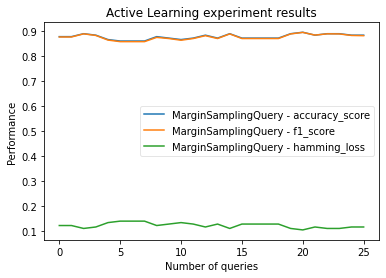

In [7]:
iterations

query_analyser = ExperimentAnalyserFactory.experiment_analyser(
                    performance_metrics=[metric.metric_name for metric in performance_metrics],
                    method_name=query_strategy.query_function_name,
                    method_results=result,
                    type="queries"
                )
# get a brief description of the experiment
query_analyser.plot_learning_curves(title='Active Learning experiment results')